In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import clean_reviews as clean
import sklearn


In [3]:

# !pip install scikit-learn==1.0.2
# print('The nltk version is {}.'.format(nltk.__version__))
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [4]:
df = pd.read_csv('./amz_tshirt_reviews.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40521 entries, 0 to 40520
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  40521 non-null  object 
 1   attr          0 non-null      float64
 2   scores        40441 non-null  object 
 3   review_title  40441 non-null  object 
 4   reviews       40521 non-null  object 
dtypes: float64(1), object(4)
memory usage: 1.5+ MB


In [6]:
# using dictionary to convert specific columns
convert_dict = {'product_name': str,
                'attr': str,
				'review_title' : str,
                'reviews' : str
               }
df = df.astype(convert_dict)

#### when I webscrapped the data, I had a bug that caused the 'attr' column to be null, I need to re-run the webscrapping ipynb file and get the complete dataset 

In [7]:
df.shape

(40521, 5)

In [8]:
df.sample(10)

,product_name,attr,scores,review_title,reviews
18992,Amazon Essentials Women's 2-Pack V-Neck Classi...,nan,4.0 out of 5 stars,\nRun small\n,"<span class=""a-size-base review-text review-te..."
12932,Hanes Men's Beefy Heavyweight Short Sleeve T-S...,nan,2.0 out of 5 stars,\nPoor quality\n,"<span class=""a-size-base review-text review-te..."
20183,5 Pack: Men’s Dry-Fit Moisture Wicking Active ...,nan,5.0 out of 5 stars,\nWicks sweat and keeps him cooler.\n,"<span class=""a-size-base review-text review-te..."
10131,Russell Athletic Men's Cotton Performance Shor...,nan,5.0 out of 5 stars,\nWould definitely buy again !!!\n,"<span class=""a-size-base review-text review-te..."
10489,Russell Athletic Men's Cotton Performance Shor...,nan,5.0 out of 5 stars,\nGreat shirt\n,"<span class=""a-size-base review-text review-te..."
7402,"Gildan Men's Heavy Cotton T-Shirt, Style G5000...",nan,5.0 out of 5 stars,\nGood\n,"<span class=""a-size-base review-text review-te..."
536,"Gildan Men's Ultra Cotton T-Shirt, Style G2000...",nan,4.0 out of 5 stars,\nPerfect until washed.\n,"<span class=""a-size-base review-text review-te..."
192,"Gildan Men's Ultra Cotton T-Shirt, Style G2000...",nan,5.0 out of 5 stars,\nNice quality\n,"<span class=""a-size-base review-text review-te..."
4406,Fruit of the Loom Men's Stay Tucked Crew T-Shirt,nan,4.0 out of 5 stars,\nRegular size is very long\n,"<span class=""a-size-base review-text review-te..."
7744,"Gildan Men's Heavy Cotton T-Shirt, Style G5000...",nan,5.0 out of 5 stars,\nNice thick shirt\n,"<span class=""a-size-base review-text review-te..."


In [9]:
duplicate = df[df.duplicated()]
duplicate.shape


(20457, 5)

In [10]:
df.drop_duplicates(inplace=True)


## Extract review score as int

In [11]:
df.scores.fillna('9')
df.scores = df.scores.str.slice(start = 0, stop =1)

# How many products does this dataset have? 

In [12]:
df.product_name.nunique()

46

# What is the distribution of scores 

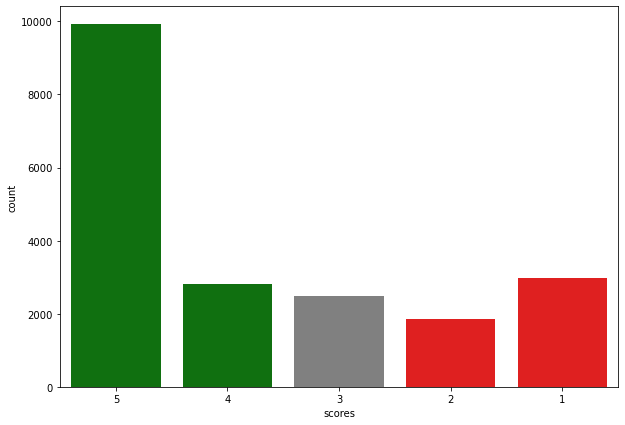

In [13]:
clrs = ['green', 'green', 'grey', 'red', 'red']
sns.countplot( data = df, x = 'scores', order = ['5', '4', '3', '2', '1'], palette=clrs)
# sb.barplot(x=idx, y=values, palette=clrs) # color=clrs)
plt.gcf().set_size_inches(10, 7)



## most of the reviews are 4 and 5 stars.
#### Since we only have few for 1 and 2 stars, I will consider 3 as a bad review. I will create a new boolean column called 'like' which answers the question: 'did the customer like the product or not?'
- 'yes': for 4 & 5 stars ratings
- 'no' :  for 3, 2, and 1 stars 

In [40]:

df.scores.isnull().sum()

38

In [14]:
df.loc[df['scores'].isnull()] = -1
df.scores = df.scores.astype(int)
def like(x):
    if x < 0:
        return None
    else:
        return x > 3

df['like'] = df.scores.apply(like)
df['like'] = df['like'].astype(bool)

<AxesSubplot:xlabel='like', ylabel='count'>

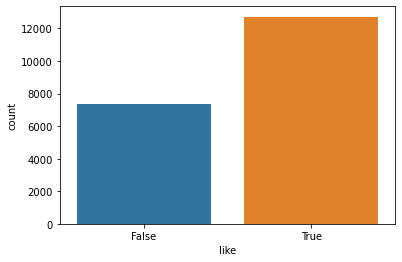

In [42]:
sns.countplot(data=df, x = 'like')

In [43]:
df.like.value_counts()

True     12721
False     7343
Name: like, dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20064 entries, 0 to 40454
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_name  20064 non-null  object
 1   attr          20064 non-null  object
 2   scores        20064 non-null  int64 
 3   review_title  20064 non-null  object
 4   reviews       20064 non-null  object
 5   like          20064 non-null  bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 1.4+ MB


In [16]:
#increase the column width to be able to view long reviews 
pd.set_option('max_colwidth', 500)
df['reviews'].sample(2)

4168     <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  These shirts were a great fit right out of the box.  I am 6'-0" and weigh 205 with a 35" waste.  I am right between large and extra large on shirts and tend to wear XL's.  I got the XL size and, right out of the box, it was just a little baggy but nearly a perfect fit.  After washing, it fits like it was custom tailored for me.  I always wear white T's under my golf shirts and have had frustrations ...
17443    <span class="a-size-base review-text review-text-content" data-hook="review-body">\n<span>\n  I ordered these in my typical womens size of XL. I am 5'6", 200 lbs, large chest, and size 14. I prefer my tops to be fitted to my body. These are what I would consider a little too big. The quality was nice and the price was great. I will definitely<br/>size down in the future. Went ahead and gave these to my sister who is a little larger than me. If you like your shirts to feel loose

## clean 'reviews' & 'review_title' column 

In [17]:

df.reviews = df.reviews.apply(clean.clean)
df.review_title = df.review_title.apply(clean.clean) 


In [22]:
# !pip install nlppreprocess

## split the reviews columns

In [23]:
df['reviews_splitted'] = df.reviews.apply(lambda x: re.split('[,.]', str(x)))

NameError: name 're' is not defined

In [ ]:
df.reviews_splitted

In [ ]:
df['review_length'] = df.reviews_splitted.apply(lambda x: len(x))

# NLTK

In [20]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

all_stopwords = stopwords.words('english')

#there are important words in reviews that I don't want to remove, such as "size up" and "size down"
do_not_remove = ['not', 'no', 'up', 'down', 'above', 'below', 'off', 'again', 'too', 'y']
for word in all_stopwords:
    if (word in do_not_remove):
        all_stopwords.remove(word)

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
len(all_stopwords)

171

In [24]:
#remove stopwords from the review_titles 
corpus=[]

for title in df['reviews']:
    title = title.split()
    title = [ps.stem(word) for word in title if not word in set(all_stopwords)]
    title = ' '.join(title)
    corpus.append(title)




In [25]:
corpus

['recommend shirt not like tight shirt bought larg happi although sure medium would work compar gilden shirt fruit loom platinum see walmart pro gilden appear better built size consist two shirt came packag neck smaller without tight guess fabric around neck not wrinkl up unlik mani fruit loom no loos thread unlik mani fruit loom gilden heavier fabric better year live east tennesse not want seethrough shirt also no one see would want wear seethrough shirt con fruit loom much softer first wash wash gildan shirt warm water two minut dryer energysav gilden tag not good fruit loom no tag cut tag without problem gilden fine gilden slightli expens brand inexpens neutral neither brand bleed color wash gilden one time not know whether fade fruit loom shirt fade take mani wash occur hope review help updat june gildan shirt bought previous held up reason well money not shrink not fade howev not get softer wash warm dri three minut energi saver purchas gildan replac one wore not wash yet bought g

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
df_cv = cv.fit_transform(corpus)
df_dtm = pd.DataFrame(df_cv.toarray()    # convert the matrix to an array 
                        , columns=cv.get_feature_names_out()   # name the columns
                        )

df_dtm.index = df.index


,aa,aaa,aaaaaand,aaaahit,aaand,aaliti,aampb,aand,ab,abajo,...,zoom,zuckerberg,zumba,ºanoth,½x,áspera,él,éste,único,über
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40450,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40451,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40452,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40453,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
df_dtm['shirt']

0        24
1         4
2        10
3         1
4         7
         ..
40450     0
40451     0
40452     0
40453     0
40454     0
Name: shirt, Length: 20064, dtype: int64

In [28]:
# finding the most commen 30 woords
Top_words = {}
for word in df_dtm.columns:
    a = df_dtm[word].sort_values(ascending=False, na_position='last').head(30)
    Top_words[word]= list(zip(a.index, a.values))

Top_words

{'aa': [(18299, 1),
  (0, 0),
  (27172, 0),
  (27179, 0),
  (27178, 0),
  (27177, 0),
  (27176, 0),
  (27175, 0),
  (27174, 0),
  (27173, 0),
  (27171, 0),
  (27181, 0),
  (27170, 0),
  (27169, 0),
  (27168, 0),
  (27167, 0),
  (27166, 0),
  (27165, 0),
  (27164, 0),
  (27180, 0),
  (27182, 0),
  (27162, 0),
  (27183, 0),
  (27198, 0),
  (27197, 0),
  (27196, 0),
  (27195, 0),
  (27194, 0),
  (27193, 0),
  (27192, 0)],
 'aaa': [(23158, 1),
  (14130, 1),
  (5256, 1),
  (0, 0),
  (27171, 0),
  (27177, 0),
  (27176, 0),
  (27175, 0),
  (27174, 0),
  (27173, 0),
  (27172, 0),
  (27170, 0),
  (27179, 0),
  (27169, 0),
  (27168, 0),
  (27167, 0),
  (27166, 0),
  (27165, 0),
  (27164, 0),
  (27178, 0),
  (27180, 0),
  (27162, 0),
  (27190, 0),
  (27197, 0),
  (27196, 0),
  (27195, 0),
  (27194, 0),
  (27193, 0),
  (27192, 0),
  (27191, 0)],
 'aaaaaand': [(20156, 1),
  (0, 0),
  (27181, 0),
  (27179, 0),
  (27178, 0),
  (27177, 0),
  (27176, 0),
  (27175, 0),
  (27174, 0),
  (27173, 0),
  (271

In [ ]:
clean("Hello there my name isn't rawan, it's Hend, I am 28 years old")